In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.3


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


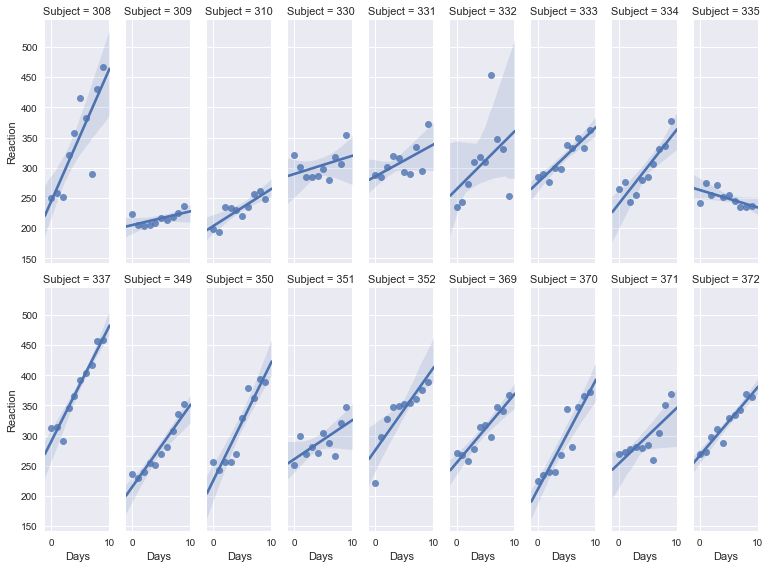

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Random effect on the intercepts

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [5]:
# Random effect on the intercepts
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.Normal('beta_X_intercept', mu=Y.mean(), sd=100)
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = pm.Deterministic('beta_X', tt.stack(beta_X_intercept, beta_X_slope))
    
    estimate_X = pm.math.dot(X, beta_X)

    sigma_Z = pm.HalfNormal('sigma_Z', sd=100)
      
    # Non Centered version
    gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset, sigma_Z_log__, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


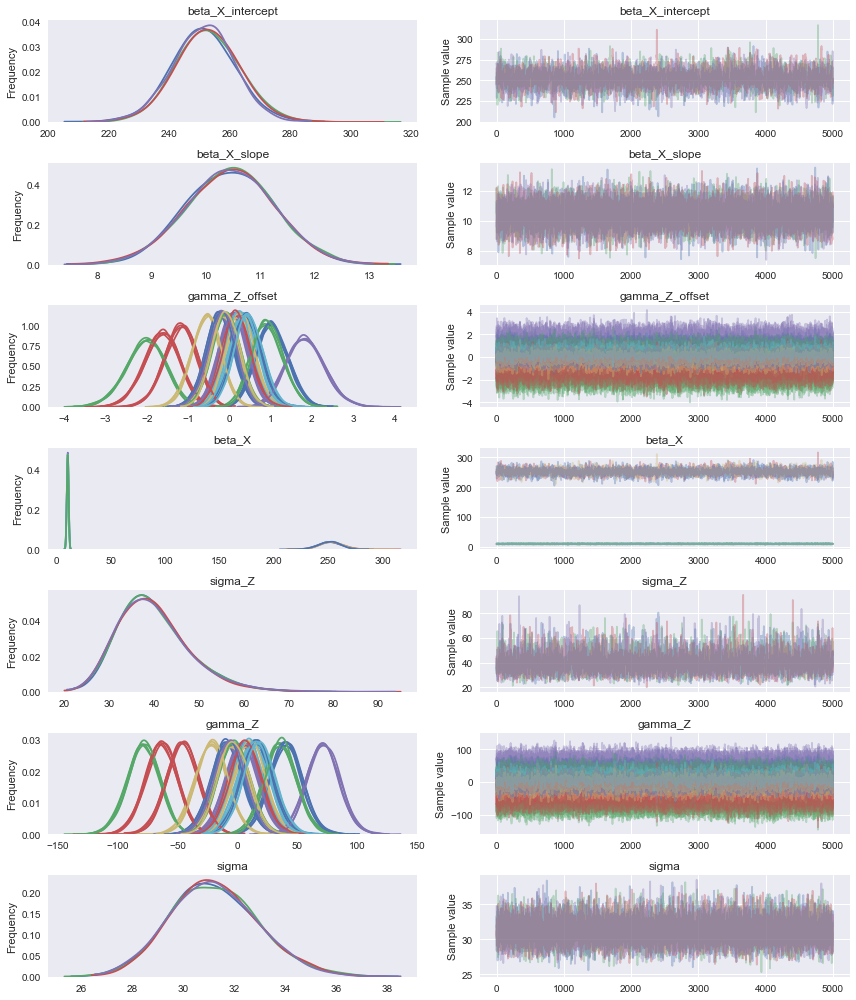

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_intercept,252.083433,10.461024,0.205437,232.652174,273.839519,2653.526551,1.003982
beta_X_slope,10.450261,0.812559,0.007412,8.859612,12.038516,12760.718793,0.999984
gamma_Z_offset__0,1.040461,0.381013,0.005654,0.293870,1.770652,4526.787583,1.001819
gamma_Z_offset__1,-2.027100,0.470582,0.006614,-2.995695,-1.158986,4471.119036,1.000918
gamma_Z_offset__2,-1.643541,0.426991,0.005821,-2.511639,-0.837456,4599.443162,1.001190
gamma_Z_offset__3,0.097780,0.338075,0.004787,-0.580164,0.747892,4397.765843,1.001599
gamma_Z_offset__4,0.249419,0.339548,0.005162,-0.377670,0.956211,4249.029427,1.002668
gamma_Z_offset__5,0.197641,0.342174,0.005170,-0.483154,0.869832,4281.326562,1.002203
gamma_Z_offset__6,0.411467,0.344708,0.005279,-0.257989,1.102866,4365.538019,1.002152
gamma_Z_offset__7,-0.091524,0.336399,0.004813,-0.744119,0.572111,4446.706859,1.002001


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD3F36BDD8>,
      dtype=object)

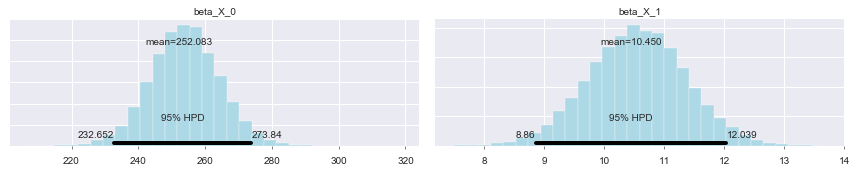

In [10]:
pm.plot_posterior(trace, varnames=['beta_X'], color='#add8e6')

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

In [11]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [12]:
# Random effect on the intercepts and slopes
#Z = patsy.dmatrix('0 + Subject + Subject:Days', data=sleep, return_type='dataframe')
#Z = np.asarray(Z)
#np.all(np.equal(Z, np.concatenate((Z_intercepts, Z_slopes), axis=1)))

Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

In [13]:
Y = np.asarray(sleep['Reaction'])

In [14]:
with pm.Model() as model:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=100000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=1000)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    sigma_Z_intercept = pm.HalfNormal('sigma_Z_intercept', sd=1000)
    gamma_Z_offset_intercept = pm.Normal('gamma_Z_offset_intercept', mu=0, sd=1000, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_offset_intercept * sigma_Z_intercept)

    sigma_Z_slope = pm.HalfNormal('sigma_Z_slope', sd=1000)
    gamma_Z_offset_slope = pm.Normal('gamma_Z_offset_slope', mu=0, sd=1000, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_offset_slope * sigma_Z_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=2, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_offset_slope, sigma_Z_slope_log__, gamma_Z_offset_intercept, sigma_Z_intercept_log__, beta_X_slope, beta_X_intercept_log__]


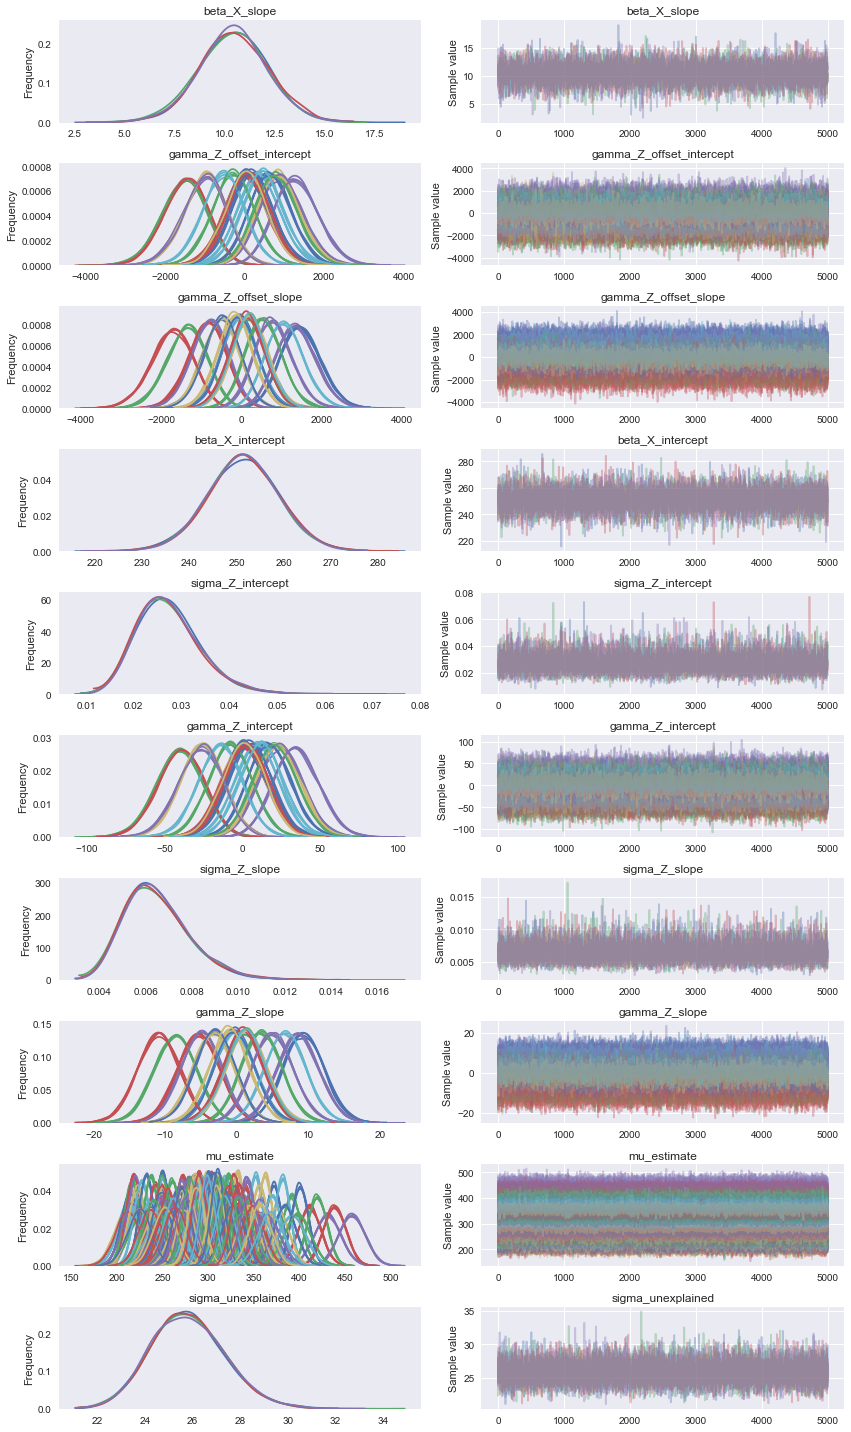

In [15]:
_ = pm.traceplot(trace)

In [16]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.448131,1.709826,0.020968,7.086649,13.837961,7667.906691,1.000713
gamma_Z_offset_intercept__0,51.105344,528.865120,3.682967,-975.501339,1121.007233,18518.773592,1.000106
gamma_Z_offset_intercept__1,-1524.382487,563.749795,4.630267,-2640.309092,-445.823618,16135.368144,1.000033
gamma_Z_offset_intercept__2,-1482.947835,548.975765,4.969721,-2535.055006,-408.077483,16696.599489,1.000112
gamma_Z_offset_intercept__3,934.896648,544.986847,4.133520,-107.178108,2028.033568,18542.266456,0.999905
gamma_Z_offset_intercept__4,873.437372,535.085591,3.754723,-195.739658,1900.018878,17144.280846,0.999911
gamma_Z_offset_intercept__5,352.216498,528.697262,3.599031,-723.346565,1373.182727,18610.570336,0.999951
gamma_Z_offset_intercept__6,649.222293,521.716461,3.458822,-338.798936,1702.230191,18652.977084,1.000013
gamma_Z_offset_intercept__7,-286.973270,524.981788,3.597124,-1294.652026,777.578086,19993.923465,0.999982
gamma_Z_offset_intercept__8,28.571889,535.865296,4.038992,-1024.612133,1093.358801,17361.008177,1.000138


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD59B282B0>,
      dtype=object)

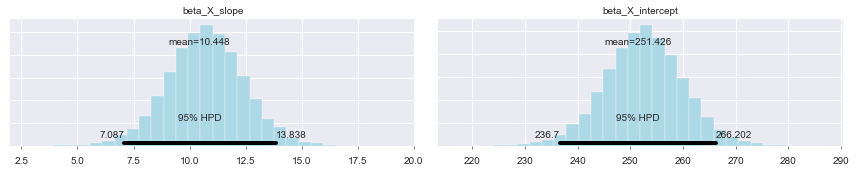

In [17]:
pm.plot_posterior(trace, varnames=['beta_X_slope', 'beta_X_intercept'], color='#add8e6')

In [18]:
trace_df = pm.trace_to_dataframe(trace)
col_to_show = [col for col in trace_df.columns if col.find('offset') == -1]
trace_df[col_to_show].head().T

,0,1,2,3,4
beta_X_slope,9.812643,12.000646,10.049663,8.382683,11.888854
beta_X_intercept,252.562118,234.765901,245.363207,257.232610,245.498959
sigma_Z_intercept,0.026537,0.022127,0.027411,0.029014,0.016006
gamma_Z_intercept__0,12.633140,-9.990935,9.431268,15.554043,-15.531603
gamma_Z_intercept__1,-51.841496,-12.615463,-54.158633,-54.724288,-18.515330
gamma_Z_intercept__2,-62.755351,-4.794676,-64.333791,-42.851024,-42.452103
gamma_Z_intercept__3,19.214165,48.878515,3.709577,15.346400,17.077323
gamma_Z_intercept__4,15.552246,29.986761,13.491987,31.121667,22.786254
gamma_Z_intercept__5,15.238209,12.685446,8.442695,5.938090,6.973505
gamma_Z_intercept__6,24.341664,21.267443,13.056999,-0.746128,19.676047


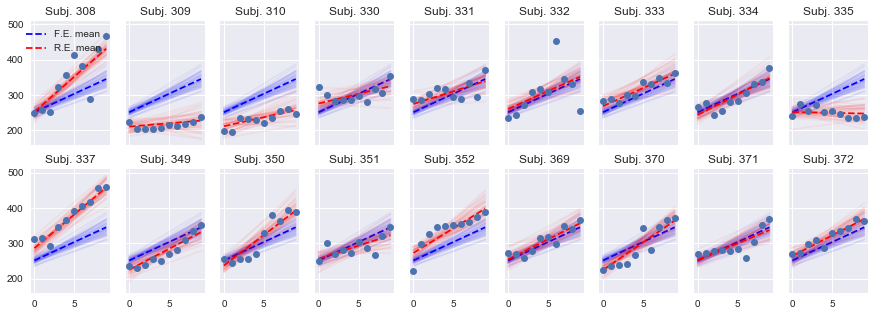

In [19]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

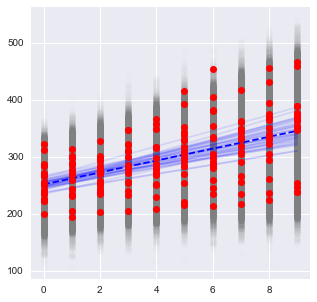

In [20]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


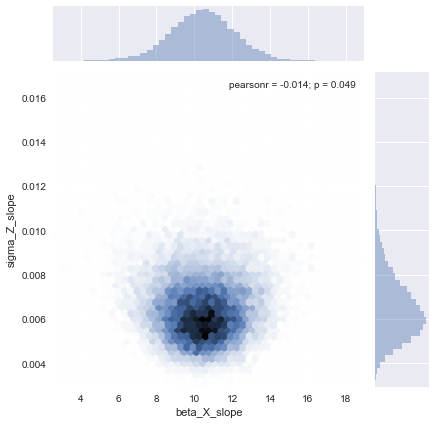

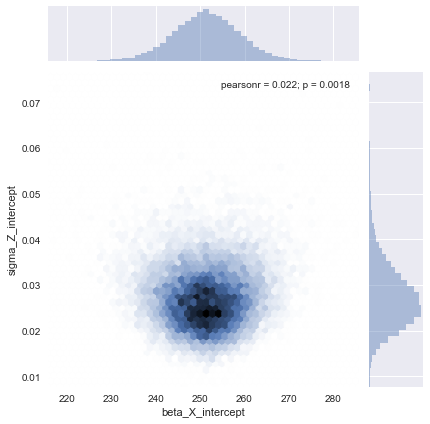

In [21]:
sns.jointplot("beta_X_slope", "sigma_Z_slope", data=trace_df, kind="hex")
sns.jointplot("beta_X_intercept", "sigma_Z_intercept", data=trace_df, kind="hex")

In [22]:
ppc = pm.sample_ppc(trace, samples=500, model=model)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1047.47it/s]


In [23]:
ppc['y_likelihood'].shape

(500, 180)

In [24]:
sleep_ppc = sleep.copy()
sleep_ppc.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


In [25]:
sleep_ppc['fit'] = ppc['y_likelihood'].mean(axis=0)

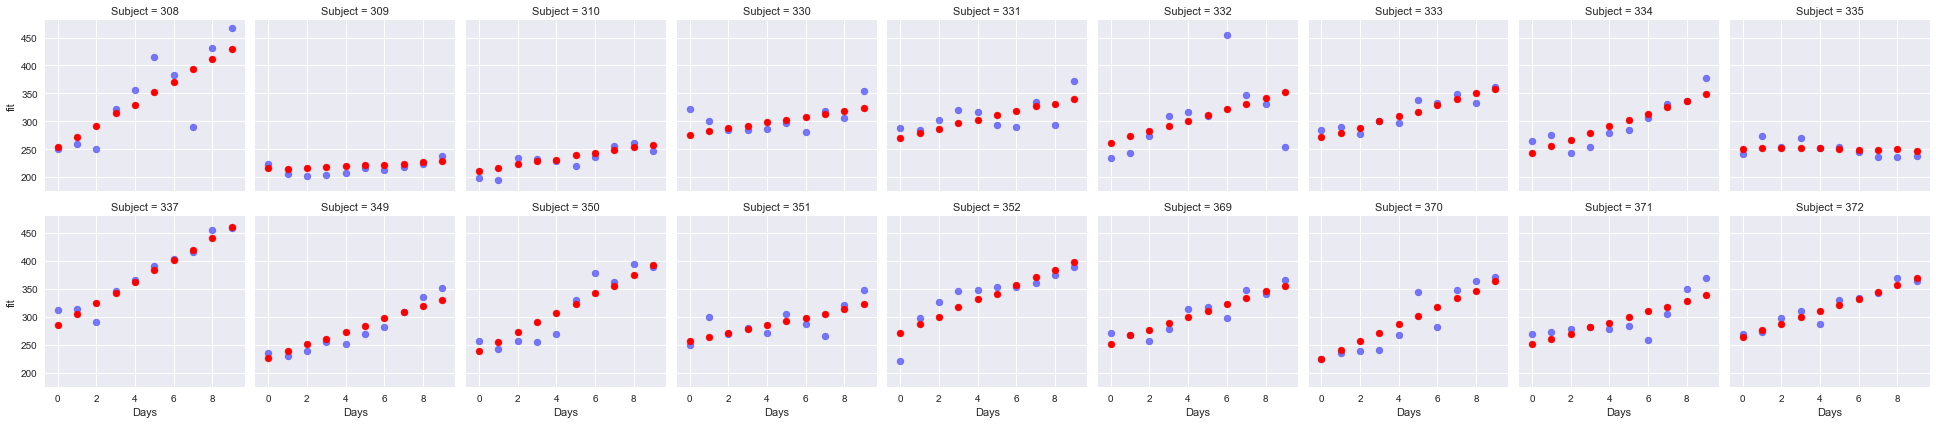

In [26]:
g = sns.FacetGrid(sleep_ppc, col="Subject", col_wrap=9)
g.map(plt.scatter, "Days", "Reaction", color='b', alpha=0.5)
g.map(plt.scatter, "Days", "fit", color='r')


## Khatri Rao product to construct Z

In [27]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [28]:
X.shape

(180, 2)

In [29]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 36)

In [30]:
np.kron(J[0, :], X[0, :]).shape

(36,)

In [31]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [32]:
Z_kr.shape

(180, 36)

In [33]:
Z.shape

(180, 36)

In [34]:
Z_kr[:10, :10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])